### Dataset Description

The dataset contains provides financial sentences with sentiment labels. The dataset was downloaded from Kaggle here: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis/data

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import nltk
import re

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
data.shape

(5842, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [7]:
data.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [8]:
# function for removing unncessary characters in sentences
def preprocess_text(text):
    # remove URLs, special characters, and numbers
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

data['cleaned_text'] = data['Sentence'].apply(preprocess_text)

In [9]:
data.head()

,Sentence,Sentiment,cleaned_text
0,The GeoSolutions technology will leverage Bene...,positive,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi lows bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sales doubled eurm...
3,According to the Finnish-Russian Chamber of Co...,neutral,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sold remaining percent sta...


In [10]:
# mappping sentiments
sentiment_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
data['Sentiment'] = data['Sentiment'].map(sentiment_dict)

In [11]:
data.head()

,Sentence,Sentiment,cleaned_text
0,The GeoSolutions technology will leverage Bene...,2,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0,esi lows bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",2,last quarter componenta net sales doubled eurm...
3,According to the Finnish-Russian Chamber of Co...,1,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,1,swedish buyout firm sold remaining percent sta...


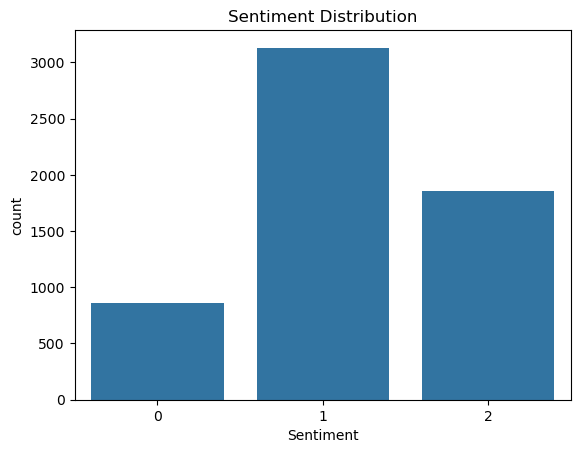

In [12]:
sns.countplot(data, x='Sentiment')
plt.title("Sentiment Distribution")
plt.show()

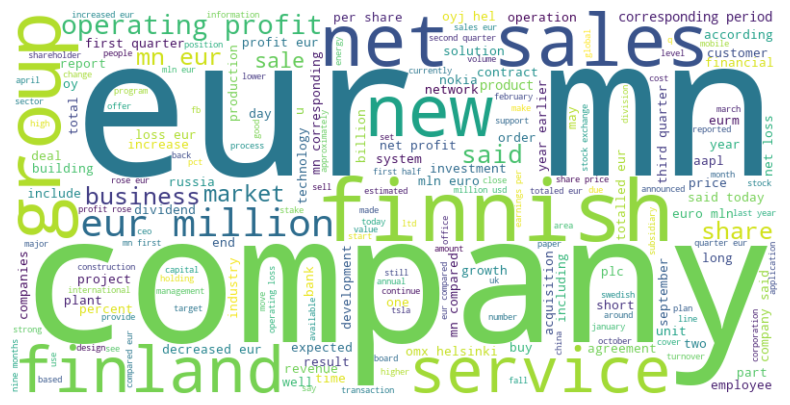

In [13]:
# word cloud for the cleaned text
text = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# splitting the data
X = data['cleaned_text']
y = data['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# vectorizing the text
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### SVM

In [16]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [17]:
y_pred_svm = svm_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print('-'*60)
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred_svm, target_names=target_names))

Accuracy: 0.6963216424294268
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.38      0.10      0.16       172
     Neutral       0.69      0.89      0.78       626
    Positive       0.75      0.64      0.69       371

    accuracy                           0.70      1169
   macro avg       0.61      0.55      0.55      1169
weighted avg       0.67      0.70      0.66      1169



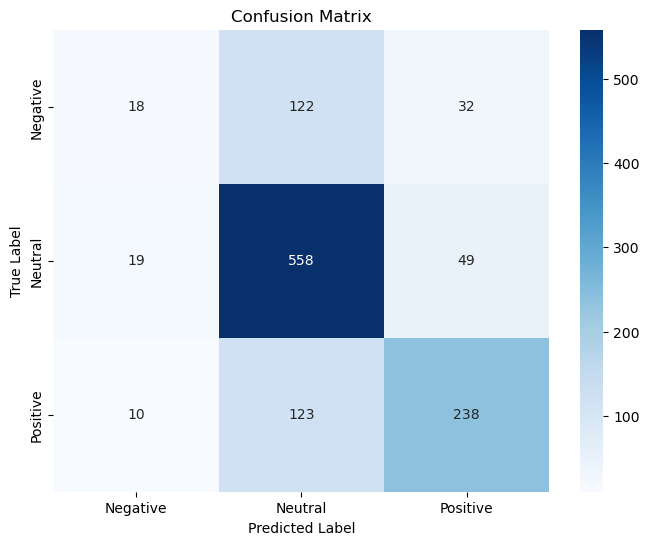

In [18]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# prediction function for SVM model
def predict_sentiment_svm(text):
    pro_text = vectorizer.transform([text])
    prediction = svm_model.predict(pro_text).reshape(-1,1)
    sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return sentiment_labels[prediction[0][0]]

new_text = "The company's profits soared this quarter!"
predicted_sentiment = predict_sentiment_svm(new_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: neutral


### LSTM 

In [20]:
# splitting the data
X = data['cleaned_text']
y = data['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
max_length = data['cleaned_text'].apply(lambda x: len(x.split())).max()

In [22]:
# tokenizing the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# converting text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# padding sequences to ensure similar length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [23]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [24]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128))
lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = lstm_model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=512, validation_data=(X_test_pad, y_test_cat))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 858ms/step - accuracy: 0.4760 - loss: 1.0551 - val_accuracy: 0.5355 - val_loss: 0.9851
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 670ms/step - accuracy: 0.5357 - loss: 0.9689 - val_accuracy: 0.5355 - val_loss: 0.9546
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 648ms/step - accuracy: 0.5559 - loss: 0.9245 - val_accuracy: 0.6116 - val_loss: 0.9071
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step - accuracy: 0.6228 - loss: 0.8461 - val_accuracy: 0.6459 - val_loss: 0.8536
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 612ms/step - accuracy: 0.6956 - loss: 0.7295 - val_accuracy: 0.6809 - val_loss: 0.7939
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 528ms/step - accuracy: 0.7468 - loss: 0.5992 - val_accuracy: 0.6912 - val_loss: 0.7808
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 720ms/step - accuracy: 0.7961 - loss: 0.4910 - val_accuracy: 0.6869 - val_loss: 0.7767
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 632ms/step - accuracy: 0.8335 - loss: 0.4232 - val_accurac

In [26]:
loss, accuracy = lstm_model.evaluate(X_test_pad, y_test_cat)
print(f'Test Accuracy: {accuracy*100:.2f}%')

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6860 - loss: 0.8821
Test Accuracy: 66.98%


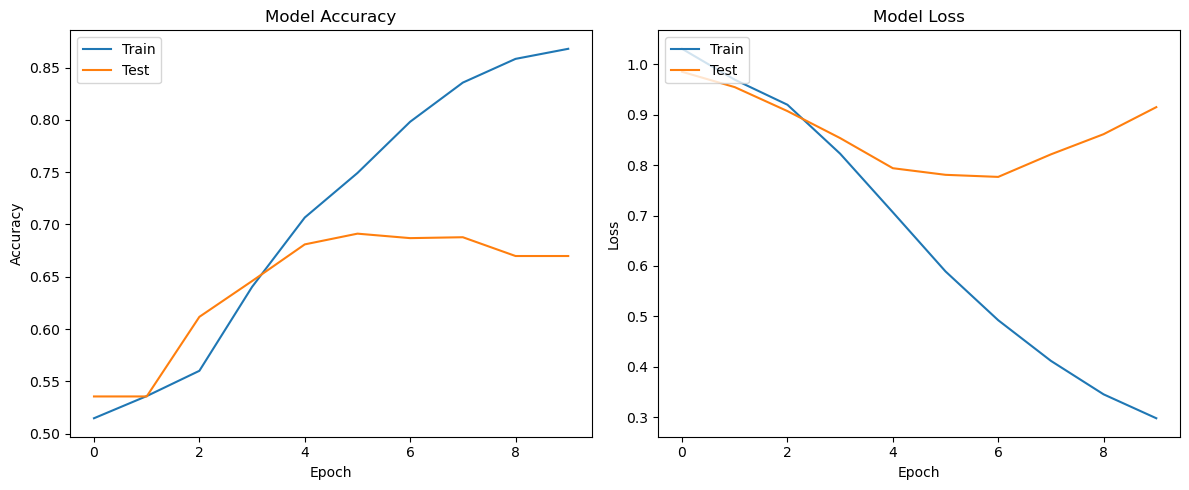

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'], loc='upper left')


axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_lstm, axis=1)
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")
print('-'*60)
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
Accuracy: 0.669803250641574
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.31      0.19      0.23       172
     Neutral       0.71      0.80      0.75       626
    Positive       0.69      0.68      0.69       371

    accuracy                           0.67      1169
   macro avg       0.57      0.55      0.56      1169
weighted avg       0.65      0.67      0.65      1169



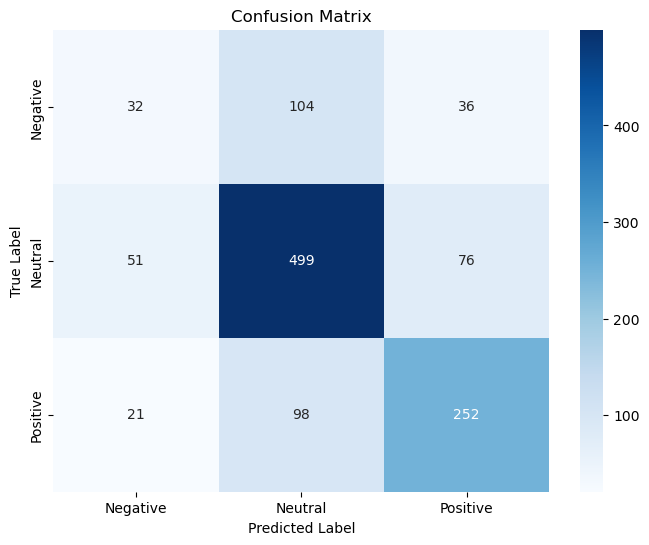

In [29]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# prediction function for lstm model
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    prediction = lstm_model.predict(padded)
    sentiment = np.argmax(prediction, axis=1)[0]
    sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return sentiment_labels[sentiment]

new_text = "The company's profits soared this quarter!"
predicted_sentiment = predict_sentiment(new_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Sentiment: neutral


### Model Comparison

In [31]:
# evaluation function
def evaluation(actual, predicted):
    Accuracy = np.round(accuracy_score(actual, predicted), 2) 
    Precision = np.round(precision_score(actual, predicted, average='weighted'), 2) 
    Recall = np.round(recall_score(actual, predicted, average='weighted'), 2) 
    F1_Score = np.round(f1_score(actual, predicted, average='weighted'), 2)

    result = {'Accuracy':Accuracy, 'Precision':Precision,'Recall':Recall,'F1_Score':F1_Score}
  
    return result

In [32]:
lstm_evaluation = evaluation(y_test, y_pred_classes)
svm_evaluation = evaluation(y_test, y_pred_svm)

In [33]:
model_eval = pd.DataFrame({
    "LSTM": lstm_evaluation,
    "Support Vector Classfier": svm_evaluation,
})
model_eval

,LSTM,Support Vector Classfier
Accuracy,0.67,0.70
Precision,0.65,0.67
Recall,0.67,0.70
F1_Score,0.65,0.66
